In [63]:
# pip install yfinance matplotlib pandas


# Step 1: yFinance and setting the GRound Rules

### Import required libraries

In [64]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

### Function to fetch historical stock data

In [65]:

def fetch_stock_data(ticker, start_date, end_date):
    # Litterally just a shorthand but almost pointless
    stock_data = yf.download(ticker, start=start_date, end=end_date)
    return stock_data


### Function to visualize stock data

In [66]:
def stock_plot(stock_data, ticker):
    # formalise the stock plot 
    plt.figure(figsize=(12, 6))
    plt.plot(stock_data['Close'], label=f"{ticker} Close Price")
    plt.title(f"{ticker} Stock Price Over Time")
    plt.xlabel("Date")
    plt.ylabel("Close Price (USD)")
    plt.legend()
    plt.grid()
    plt.show()

[*********************100%***********************]  1 of 1 completed

Price            Close        High         Low        Open    Volume
Ticker            AAPL        AAPL        AAPL        AAPL      AAPL
Date                                                                
2023-10-02  172.675461  173.222062  169.872894  170.161109  52164500
2023-10-03  171.333786  172.556190  169.763571  171.194652  49594600
2023-10-04  172.586014  173.132615  169.912648  170.031901  53020300
2023-10-05  173.828278  174.364931  171.612058  172.715194  48527900
2023-10-06  176.392349  176.889257  172.108991  172.725167  57224100


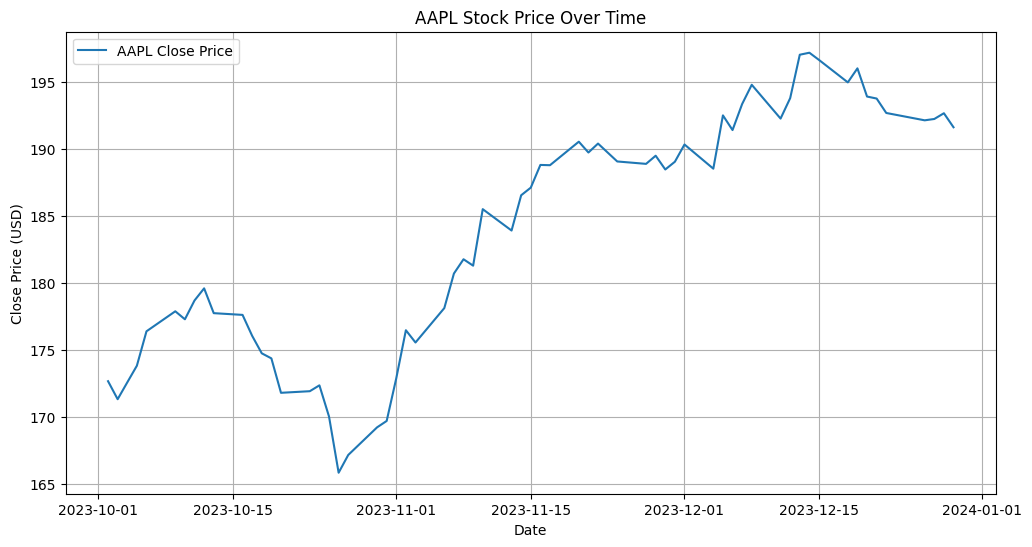

In [67]:
# Example usage
if __name__ == "__main__":
    # Define parameters
    ticker = "AAPL"  # Apple stock
    start_date = "2023-10-01"
    end_date = "2023-12-31"

    # Fetch stock data
    stock_data = fetch_stock_data(ticker, start_date, end_date)

    # Display the first few rows
    print(stock_data.head())

    # Visualize the stock data
    stock_plot(stock_data, ticker)


# Step 2: Formalising the Training.
### This can be sub optimal for now as this hopefully will be replaced with later this can be GCP AutoML or something groovey like that.
---
#### Initial Thoughts : 
XGBoost and LSTM are clearly going to perform well here so lets just cut to the chase and when I have a half decent something lets see about using some hyperparamter optimisation going. This bit should be easy but the POC will be using this with an App

---

#### 2.1 More Imports

In [68]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error
# hyper param in just grid search not bayseian for now :)
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
import tensorflow as tfx

### 2.2 Function to Prepare the data

In [69]:
def prepare_lstm_data(data, target_column, look_back=30):
# Just grab some data and chuck them in X and y 
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:i + look_back])
        y.append(data[i + look_back])
    return np.array(X), np.array(y)

### 2.3 Eg: Grab some AAPL 

In [70]:
# Fetch stock data using the functions
ticker = "AAPL"
start_date = "2023-01-01"
end_date = "2023-12-31"
stock_data = fetch_stock_data(ticker, start_date, end_date)


[*********************100%***********************]  1 of 1 completed


### 2.4 PreProcess  Numero 1: Normalise Close

In [71]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(stock_data[['Close']].values)

look_back = 30  # Number of days to look back
X, y = prepare_lstm_data(scaled_data, target_column='Close', look_back=look_back)

### 2.5 Admin with the Data

In [72]:
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape 
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

### 2.6 Define LSTM  

In [73]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error') # ls and adam 

# Train the model
history = model.fit(X_train, y_train, batch_size=32, epochs=20, validation_data=(X_test, y_test))

# Evaluate the model
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)
y_test_unscaled = scaler.inverse_transform(y_test.reshape(-1, 1))


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.3284 - val_loss: 0.0054
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0472 - val_loss: 0.0033
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0166 - val_loss: 0.0628
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0251 - val_loss: 0.0286
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0128 - val_loss: 0.0031
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0114 - val_loss: 0.0067
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0108 - val_loss: 0.0239
Epoch 8/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0104 - val_loss: 0.0154
Epoch 9/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0098 - val_loss: 0.0050
Epoch 10/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0093 - val_loss: 0.0091
Epoch 11/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0080 - val_loss: 0.0135
Epoch 12/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0095 - val_loss: 0.0083
Epoch 13/20


### 2.7 Visualisation of Model Performance

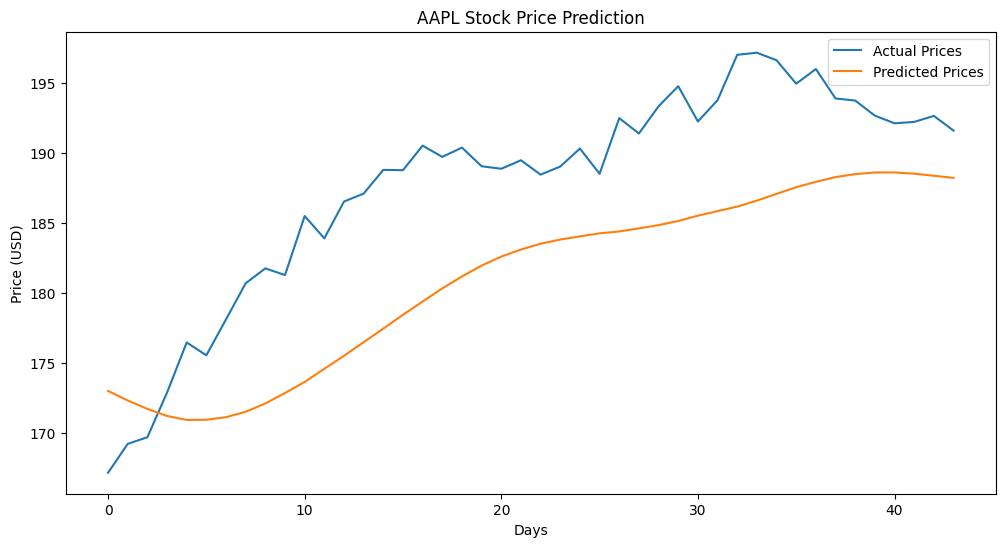

Root Mean Squared Error: 7.659833321139211


In [74]:

# Plot actual vs predicted
plt.figure(figsize=(12, 6))
plt.plot(y_test_unscaled, label="Actual Prices")
plt.plot(predictions, label="Predicted Prices")
plt.title(f"{ticker} Stock Price Prediction")
plt.xlabel("Days")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test_unscaled, predictions))
print(f"Root Mean Squared Error: {rmse}")


Secondary Thoguhts : This serves as a POC, AutoML willl outperform so maybe shouldnt spend too much tiem trying the XGBoost alternative...
But lets try anyway

### More Imports for XGBoost & hyperparam optimisation 

In [75]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
import tensorflow as tf

## 3. Model Selection 
### 3.1 LSTM vs XGBoost Model 

In [76]:

def build_lstm_model(units=50, dropout_rate=0.2):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.LSTM(units, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(tf.keras.layers.Dropout(dropout_rate))
    model.add(tf.keras.layers.LSTM(units, return_sequences=False))
    model.add(tf.keras.layers.Dropout(dropout_rate))
    model.add(tf.keras.layers.Dense(25))
    model.add(tf.keras.layers.Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')  # Loss = MSE
    return model

# Train and Evaluate LSTM
def train_lstm(X_train, y_train, X_test, y_test, units=50, dropout_rate=0.2, epochs=20):
    model = build_lstm_model(units, dropout_rate)
    history = model.fit(X_train, y_train, batch_size=32, epochs=epochs, validation_data=(X_test, y_test), verbose=1)
    predictions = model.predict(X_test)
    return model, predictions

# Train and Evaluate XGBoost
def train_xgboost(X_train, y_train, X_test, y_test):
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.2],
    }
    xgb = XGBRegressor(objective='reg:squarederror', n_jobs=-1)
    grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1)
    grid_search.fit(X_train.reshape(X_train.shape[0], -1), y_train)
    best_xgb = grid_search.best_estimator_
    predictions = best_xgb.predict(X_test.reshape(X_test.shape[0], -1))
    return best_xgb, predictions


### 3.2 Deploying code

In [77]:

# Train Both Models
lstm_model, lstm_predictions = train_lstm(X_train, y_train, X_test, y_test, units=50, dropout_rate=0.2, epochs=20)
xgb_model, xgb_predictions = train_xgboost(X_train, y_train, X_test, y_test)

# Inverse transform predictions
lstm_predictions = scaler.inverse_transform(lstm_predictions)
xgb_predictions = scaler.inverse_transform(xgb_predictions.reshape(-1, 1))
y_test_unscaled = scaler.inverse_transform(y_test.reshape(-1, 1))


Epoch 1/20


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.5076 - val_loss: 0.0799
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0388 - val_loss: 0.0095
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0216 - val_loss: 0.0502
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0250 - val_loss: 0.0350
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0121 - val_loss: 0.0043
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0153 - val_loss: 0.0071
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0095 - val_loss: 0.0190
Epoch 8/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0132 - val_loss: 0.0131
Epoch 9/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0107 - val_loss: 0.0077
Epoch 10/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0075 - val_loss: 0.0110
Epoch 11/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0095 - val_loss: 0.0111
Epoch 12/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0080 - val_loss: 0.0095
Epoch 13/20
6/6 ━━━━━━━

### 3.3 Model Visualisation

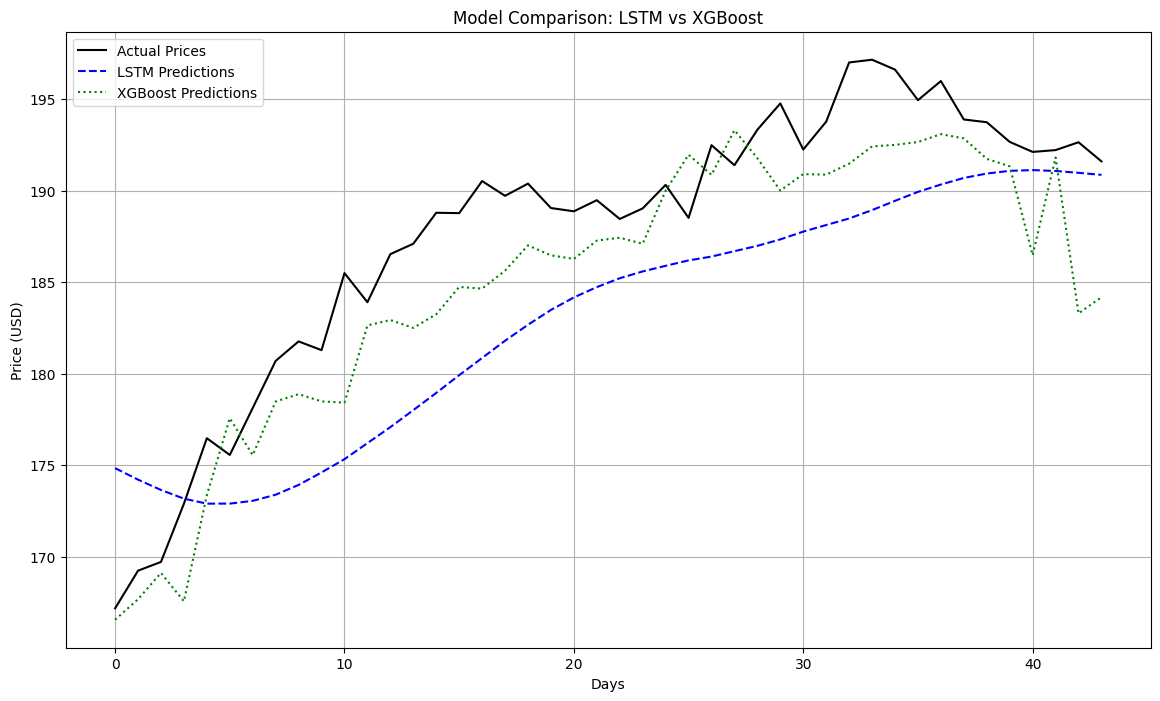

LSTM RMSE: 6.092073241482389
XGBoost RMSE: 3.722627374073714
The XGBoost model performed better.


In [78]:

# Plot Comparison
plt.figure(figsize=(14, 8))
plt.plot(y_test_unscaled, label="Actual Prices", color='black')
plt.plot(lstm_predictions, label="LSTM Predictions", color='blue', linestyle='dashed')
plt.plot(xgb_predictions, label="XGBoost Predictions", color='green', linestyle='dotted')
plt.title("Model Comparison: LSTM vs XGBoost")
plt.xlabel("Days")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid()
plt.show()

# Evaluate Both Models
from sklearn.metrics import mean_squared_error
lstm_rmse = np.sqrt(mean_squared_error(y_test_unscaled, lstm_predictions))
xgb_rmse = np.sqrt(mean_squared_error(y_test_unscaled, xgb_predictions))

print(f"LSTM RMSE: {lstm_rmse}")
print(f"XGBoost RMSE: {xgb_rmse}")

# Choose the Best Model
if lstm_rmse < xgb_rmse:
    print("The LSTM model performed better.")
    best_model = lstm_model
else:
    print("The XGBoost model performed better.")
    best_model = xgb_model


## 4. Lets make a function to encapsulate this process so its much easier to call.

In [79]:
def AutoML(stock_ticker):
    # Fetch stock data using the functions
    ticker = stock_ticker
    start_date = "2023-01-01"
    end_date = "2024-12-31"
    stock_data = fetch_stock_data(ticker, start_date, end_date)

    # Scale the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(stock_data[['Close']].values)

    look_back = 30  # Number of days to look back

    
    # Train on the last year minus 30 days, test on the last 30 days
    train_end_index = len(scaled_data) - look_back - 30  # Training data excludes the last 30 days
    X_train, y_train = prepare_lstm_data(scaled_data[:train_end_index], target_column='Close', look_back=look_back)
    X_test, y_test = prepare_lstm_data(scaled_data[train_end_index:], target_column='Close', look_back=look_back)

    # Reshape for LSTM
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

    # Train Both Models
    lstm_model, lstm_predictions = train_lstm(X_train, y_train, X_test, y_test, units=50, dropout_rate=0.2, epochs=20)
    xgb_model, xgb_predictions = train_xgboost(X_train, y_train, X_test, y_test)

    # Inverse transform predictions
    lstm_predictions = scaler.inverse_transform(lstm_predictions)
    xgb_predictions = scaler.inverse_transform(xgb_predictions.reshape(-1, 1))
    y_test_unscaled = scaler.inverse_transform(y_test.reshape(-1, 1))

    # Plot Comparison
    plt.figure(figsize=(14, 8))
    plt.plot(y_test_unscaled, label="Actual Prices", color='black')
    plt.plot(lstm_predictions, label="LSTM Predictions", color='blue', linestyle='dashed')
    plt.plot(xgb_predictions, label="XGBoost Predictions", color='green', linestyle='dotted')
    plt.title("Model Comparison: LSTM vs XGBoost")
    plt.xlabel("Days")
    plt.ylabel("Price (USD)")
    plt.legend()
    plt.grid()
    plt.show()

    # Evaluate Both Models
    from sklearn.metrics import mean_squared_error
    lstm_rmse = np.sqrt(mean_squared_error(y_test_unscaled, lstm_predictions))
    xgb_rmse = np.sqrt(mean_squared_error(y_test_unscaled, xgb_predictions))

    print(f"LSTM RMSE: {lstm_rmse}")
    print(f"XGBoost RMSE: {xgb_rmse}")

    # Choose the Best Model
    if lstm_rmse < xgb_rmse:
        print("The LSTM model performed better.")
        best_model = lstm_model
    else:
        print("The XGBoost model performed better.")
        best_model = xgb_model

    return best_model


[*********************100%***********************]  1 of 1 completed

Epoch 1/20



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.1535 - val_loss: 0.0191
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0192 - val_loss: 0.0026
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0123 - val_loss: 0.0163
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0086 - val_loss: 0.0019
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0074 - val_loss: 0.0033
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0059 - val_loss: 0.0037
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0053 - val_loss: 0.0030
Epoch 8/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0050 - val_loss: 0.0017
Epoch 9/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0046 - val_loss: 0.0018
Epoch 10/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0046 - val_loss: 0.0044
Epoch 11/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0046 - val_loss: 0.0034
Epoch 12/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0048 - val_loss: 0.0030

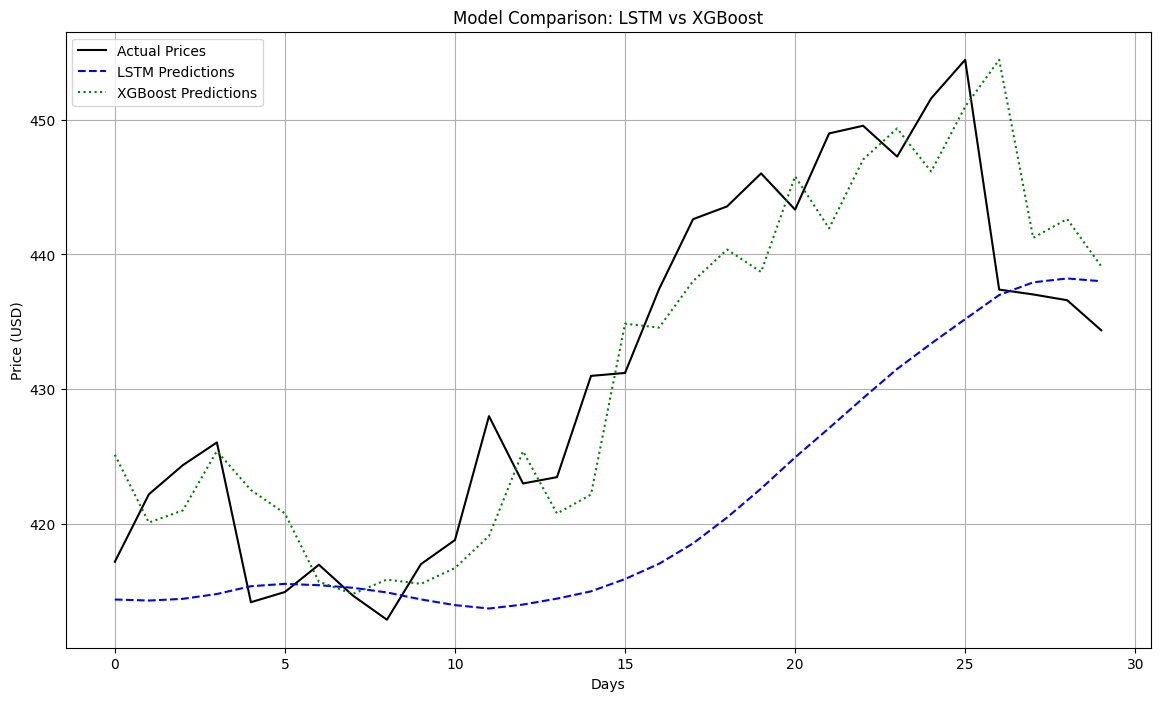

LSTM RMSE: 13.49585090185244
XGBoost RMSE: 5.635281773132424
The XGBoost model performed better.


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=-1,
             num_parallel_tree=None, random_state=None, ...)

In [80]:
AutoML('MSFT')

### 4.1 Another Example of the AutoML in action

[*********************100%***********************]  1 of 1 completed

Epoch 1/20



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0727 - val_loss: 0.0321
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0128 - val_loss: 0.0037
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0063 - val_loss: 0.0018
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0045 - val_loss: 0.0016
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0030 - val_loss: 0.0022
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0037 - val_loss: 0.0017
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0032 - val_loss: 0.0015
Epoch 8/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0036 - val_loss: 0.0013
Epoch 9/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0039 - val_loss: 0.0026
Epoch 10/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0034 - val_loss: 0.0022
Epoch 11/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0024 - val_loss: 0.0013
Epoch 12/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0026 - val_loss: 0.00

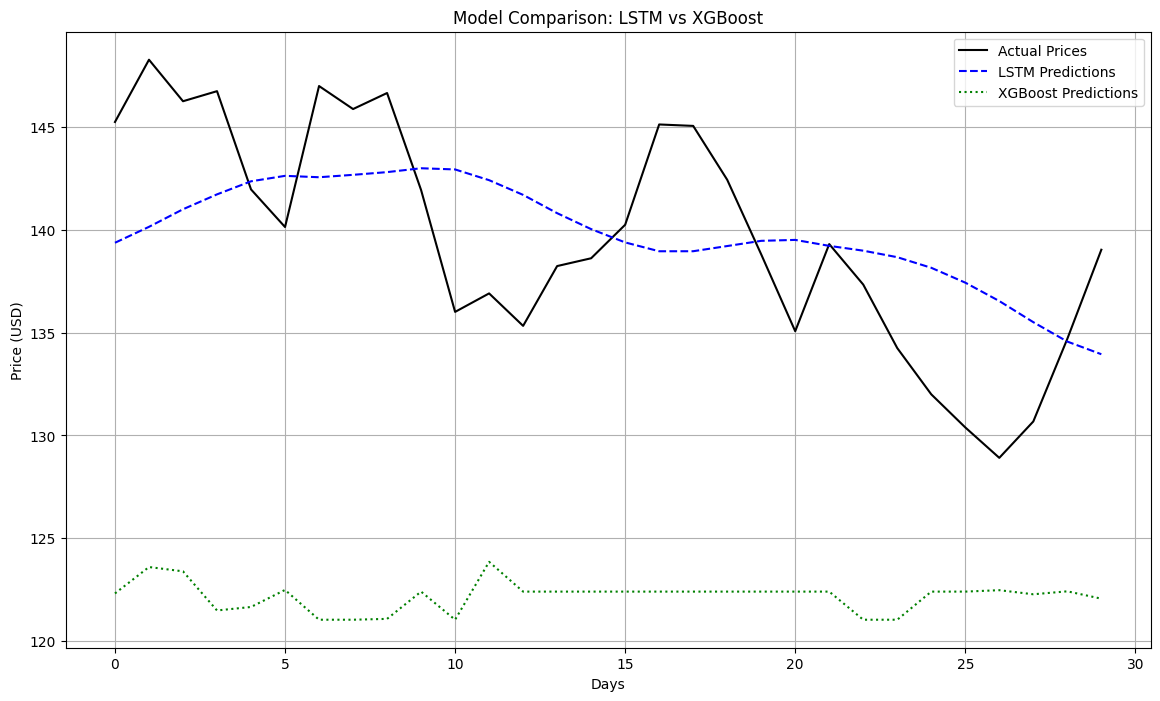

LSTM RMSE: 4.680038801545744
XGBoost RMSE: 18.29220000080764
The LSTM model performed better.


<Sequential name=sequential_26, built=True>

In [81]:
AutoML('NVDA')

### 4.2 More Holistic View of Training Testing Split

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


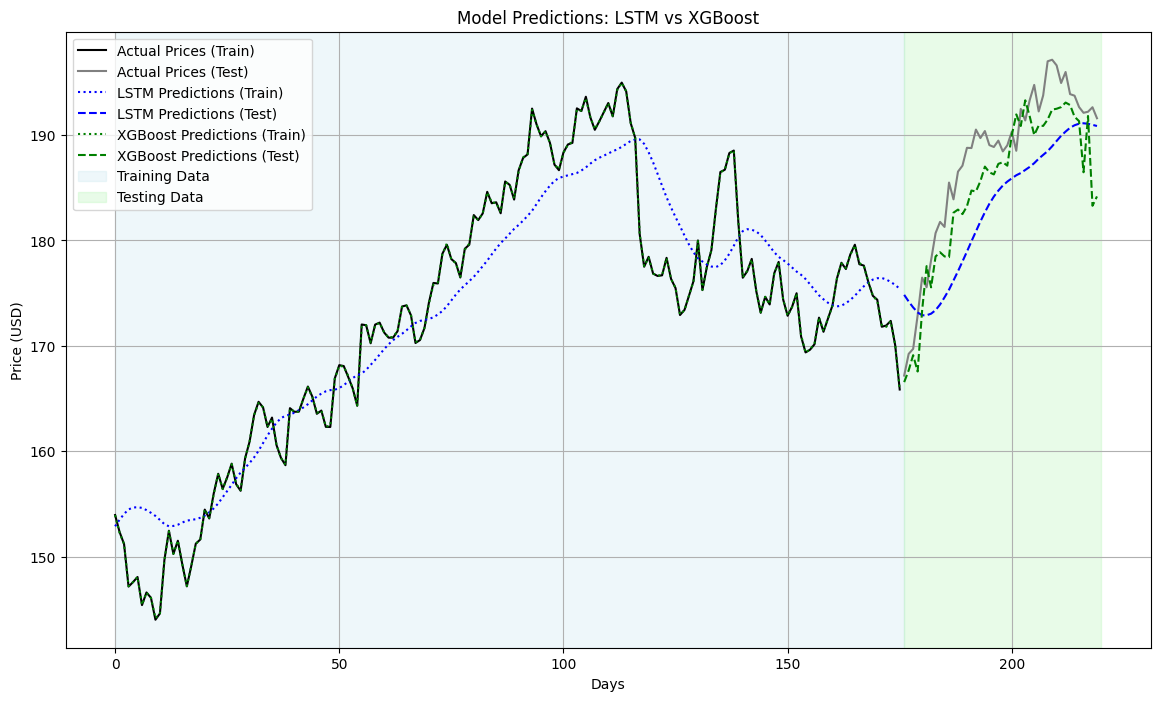

In [82]:
# Plot Comparison with Background Colors
plt.figure(figsize=(14, 8))

# Plot actual prices
plt.plot(range(len(y_train)), scaler.inverse_transform(y_train.reshape(-1, 1)), label="Actual Prices (Train)", color='black')
plt.plot(range(len(y_train), len(y_train) + len(y_test)), y_test_unscaled, label="Actual Prices (Test)", color='gray')

# Plot LSTM predictions
plt.plot(range(len(y_train)), scaler.inverse_transform(lstm_model.predict(X_train)), label="LSTM Predictions (Train)", color='blue', linestyle='dotted')
plt.plot(range(len(y_train), len(y_train) + len(y_test)), lstm_predictions, label="LSTM Predictions (Test)", color='blue', linestyle='dashed')

# Plot XGBoost predictions
plt.plot(range(len(y_train)), scaler.inverse_transform(xgb_model.predict(X_train.reshape(X_train.shape[0], -1)).reshape(-1, 1)), label="XGBoost Predictions (Train)", color='green', linestyle='dotted')
plt.plot(range(len(y_train), len(y_train) + len(y_test)), xgb_predictions, label="XGBoost Predictions (Test)", color='green', linestyle='dashed')

# Highlight training and testing regions
plt.axvspan(0, len(y_train), color='lightblue', alpha=0.2, label='Training Data')
plt.axvspan(len(y_train), len(y_train) + len(y_test), color='lightgreen', alpha=0.2, label='Testing Data')

# Add titles and labels
plt.title("Model Predictions: LSTM vs XGBoost")
plt.xlabel("Days")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid()
plt.show()


### 4.3 Train on all data and Predict on Future Dates now 

In [83]:
def AutoML2(stock_ticker):
    # Fetch stock data
    ticker = stock_ticker
    start_date = "2023-01-01"
    end_date = "2024-12-31"
    stock_data = fetch_stock_data(ticker, start_date, end_date)

    # Scale the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(stock_data[['Close']].values)

    look_back = 30  # Number of days to look back

    # Prepare training and testing data
    train_end_index = len(scaled_data) - look_back - 30  # Training data excludes the last 30 days
    X_train, y_train = prepare_lstm_data(scaled_data[:train_end_index], target_column='Close', look_back=look_back)
    X_test, y_test = prepare_lstm_data(scaled_data[train_end_index:], target_column='Close', look_back=look_back)

    # Reshape for LSTM
    X_train_lstm = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test_lstm = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

    # Train Both Models
    lstm_model, lstm_predictions = train_lstm(X_train_lstm, y_train, X_test_lstm, y_test, units=50, dropout_rate=0.2, epochs=20)
    xgb_model, xgb_predictions = train_xgboost(X_train, y_train, X_test, y_test)

    # Inverse transform predictions
    lstm_predictions = scaler.inverse_transform(lstm_predictions)
    xgb_predictions = scaler.inverse_transform(xgb_predictions.reshape(-1, 1))
    y_test_unscaled = scaler.inverse_transform(y_test.reshape(-1, 1))

    # Calculate RMSE for both models
    lstm_rmse = np.sqrt(mean_squared_error(y_test_unscaled, lstm_predictions))
    xgb_rmse = np.sqrt(mean_squared_error(y_test_unscaled, xgb_predictions))

    # Determine the best model
    if lstm_rmse < xgb_rmse:
        print(f"LSTM performed better with RMSE: {lstm_rmse}")
        best_model = "LSTM"
        best_predictions = lstm_predictions
        model = lstm_model
    else:
        print(f"XGBoost performed better with RMSE: {xgb_rmse}")
        best_model = "XGBoost"
        best_predictions = xgb_predictions
        model = xgb_model

    # Train the best model on the entire dataset
    X, y = prepare_lstm_data(scaled_data, target_column='Close', look_back=look_back)
    if best_model == "LSTM":
        X_train_full = X.reshape(X.shape[0], X.shape[1], 1)  # Reshape for LSTM
        model.fit(X_train_full, y, epochs=20, verbose=1)
    else:
        model.fit(X, y)

    # Predict the next 30 days
    predictions_future = []
    last_sequence = X[-1]  # Use the last sequence from the training set

    for _ in range(30):
        if best_model == "LSTM":
            next_input = last_sequence.reshape(1, look_back, 1)
            next_pred = model.predict(next_input)
        else:
            next_input = last_sequence.reshape(1, -1)
            next_pred = model.predict(next_input)

        predictions_future.append(next_pred[0, 0] if best_model == "LSTM" else next_pred[0])

        # Update the sequence
        last_sequence = np.append(last_sequence[1:], next_pred).reshape(look_back, 1)

    predictions_future = scaler.inverse_transform(np.array(predictions_future).reshape(-1, 1)).flatten()

    # Plot Results
    plt.figure(figsize=(14, 8))

    # Historical data
    plt.plot(range(len(scaled_data)), scaler.inverse_transform(scaled_data), label="Historical Prices", color='black')

    # Training region
    plt.axvspan(0, train_end_index, color='lightblue', alpha=0.2, label='Training Data')

    # Testing region
    plt.axvspan(train_end_index, len(scaled_data), color='lightgreen', alpha=0.2, label='Testing Data')

    # Future predictions
    plt.plot(range(len(scaled_data), len(scaled_data) + 30), predictions_future, label=f"{best_model} Predictions (Future)", color='orange', linestyle='dashed')

    # Add labels, title, and legend
    plt.title("Historical and Future Predictions with Best Model")
    plt.xlabel("Days")
    plt.ylabel("Price (USD)")
    plt.legend()
    plt.grid()
    plt.show()

    return predictions_future


[*********************100%***********************]  1 of 1 completed

Epoch 1/20



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0912 - val_loss: 0.0573
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0154 - val_loss: 0.0061
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0064 - val_loss: 0.0341
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0060 - val_loss: 0.0082
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0053 - val_loss: 0.0092
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0051 - val_loss: 0.0021
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0044 - val_loss: 0.0071
Epoch 8/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0049 - val_loss: 0.0060
Epoch 9/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0043 - val_loss: 0.0021
Epoch 10/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0048 - val_loss: 0.0030
Epoch 11/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0047 - val_loss: 0.0052
Epoch 12/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0037 - val_loss: 0.0046

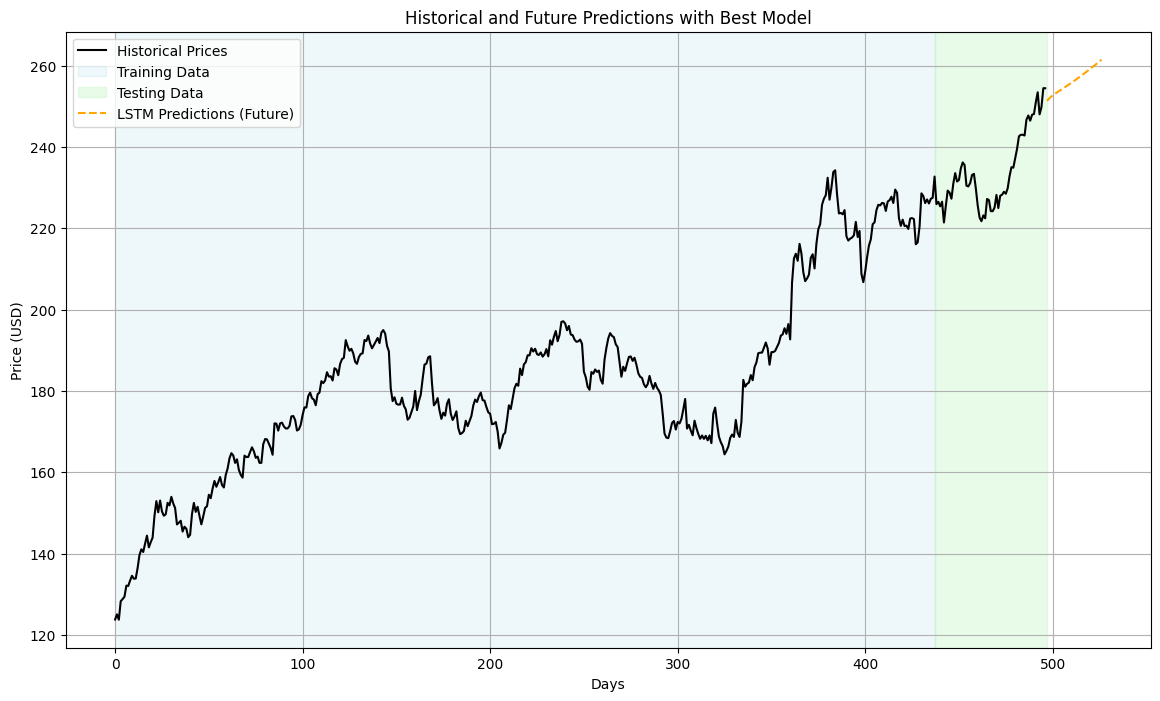

In [84]:
predictions = AutoML2('AAPL')

### 4.4 Classify the next Day, Week and Month Predictions.

In [85]:
def classify_prediction_outcome(predictions, time_range="day", threshold=0.005):
    # Day, Week Month Classification

    # Define time range mapping
    time_range_map = {
        "day": 1,
        "week": 7,
        "month": 30
    }

    # Ensure time_range is valid
    if time_range not in time_range_map:
        raise ValueError(f"Invalid time_range. Choose from {list(time_range_map.keys())}.")

    # Determine the time step for the specified range
    steps = time_range_map[time_range]
    if steps > len(predictions):
        raise ValueError(f"Time range ({time_range}) exceeds prediction range ({len(predictions)} days).")

    # Calculate the percentage change over the time range
    start_price = predictions[0]
    end_price = predictions[steps - 1]
    percentage_change = (end_price - start_price) / start_price

    # Classify the outcome
    if percentage_change > threshold:
        outcome = "Gain"
    elif percentage_change < -threshold:
        outcome = "Loss"
    else:
        outcome = "No Changes"

    return {
        "time_range": time_range,
        "percentage_change": percentage_change * 100,  # Convert to percentage
        "outcome": outcome
    }


### 4.5 Encapsualte the Code in a simple function 

In [ ]:

def classify_preds(future_predictions):
        
    # Classify for a day
    result_day = classify_prediction_outcome(future_predictions, time_range="day")
    print(f"Day Classification: {result_day}")

    # Classify for a week
    result_week = classify_prediction_outcome(future_predictions, time_range="week")
    print(f"Week Classification: {result_week}")

    # Classify for a month
    result_month = classify_prediction_outcome(future_predictions, time_range="month")
    print(f"Month Classification: {result_month}")
    
    return(result_day, result_week, result_month)


### 4.6 Prediction and classification Example Useage


[*********************100%***********************]  1 of 1 completed

Epoch 1/20



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1361 - val_loss: 0.0017
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0158 - val_loss: 0.0173
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0090 - val_loss: 0.0070
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0056 - val_loss: 0.0102
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0043 - val_loss: 0.0016
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0039 - val_loss: 0.0014
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0033 - val_loss: 0.0013
Epoch 8/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0030 - val_loss: 0.0016
Epoch 9/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0033 - val_loss: 0.0028
Epoch 10/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0041 - val_loss: 0.0066
Epoch 11/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0047 - val_loss: 0.0027
Epoch 12/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0038 - val_loss: 0.001

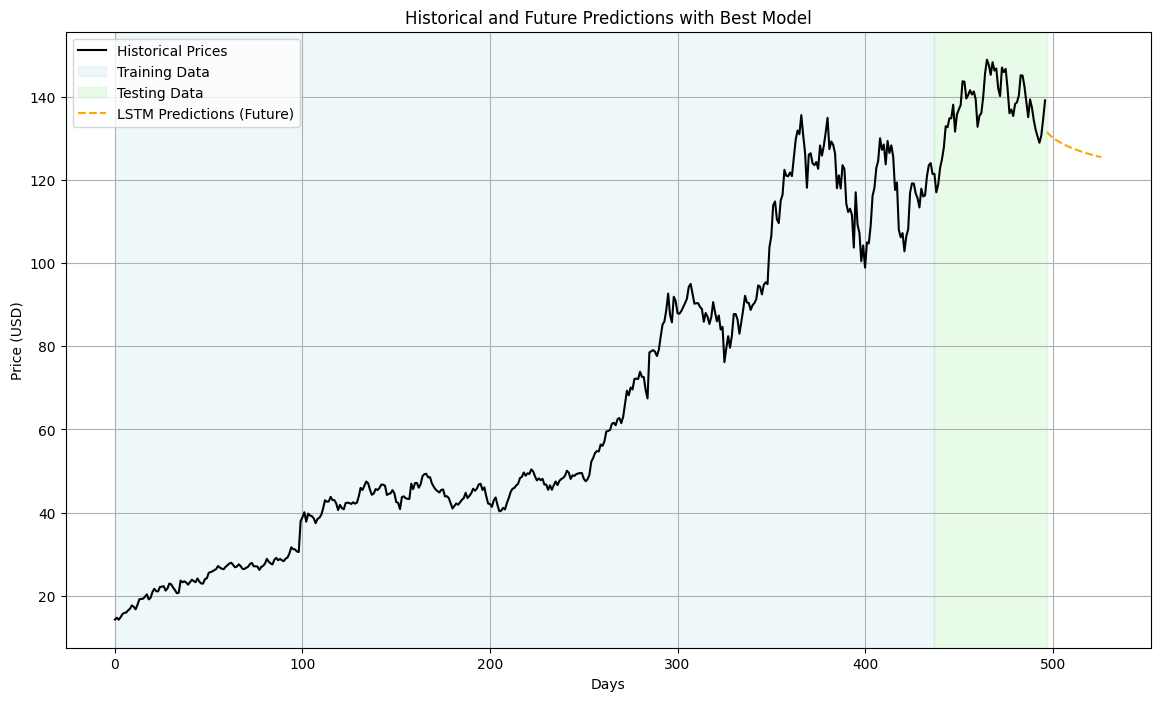

Day Classification: {'time_range': 'day', 'percentage_change': 0.0, 'outcome': 'No Changes'}
Week Classification: {'time_range': 'week', 'percentage_change': -1.6873273998498917, 'outcome': 'Loss'}
Month Classification: {'time_range': 'month', 'percentage_change': -4.594934359192848, 'outcome': 'Loss'}


({'time_range': 'day', 'percentage_change': 0.0, 'outcome': 'No Changes'},
 {'time_range': 'week',
  'percentage_change': -1.6873273998498917,
  'outcome': 'Loss'},
 {'time_range': 'month',
  'percentage_change': -4.594934359192848,
  'outcome': 'Loss'})

In [87]:
future_predictions = AutoML2('NVDA')
classify_preds(future_predictions)


Next Steps: 
- Clean the Code and flow of the notebook
- Package and Apply this or a similar process to be called on the fly by the app 
- Make an app interface 